# Analysis of Real-World Data from a Solar-Equipped Smart Home

## Notebook 1: Data cleaning + preparation

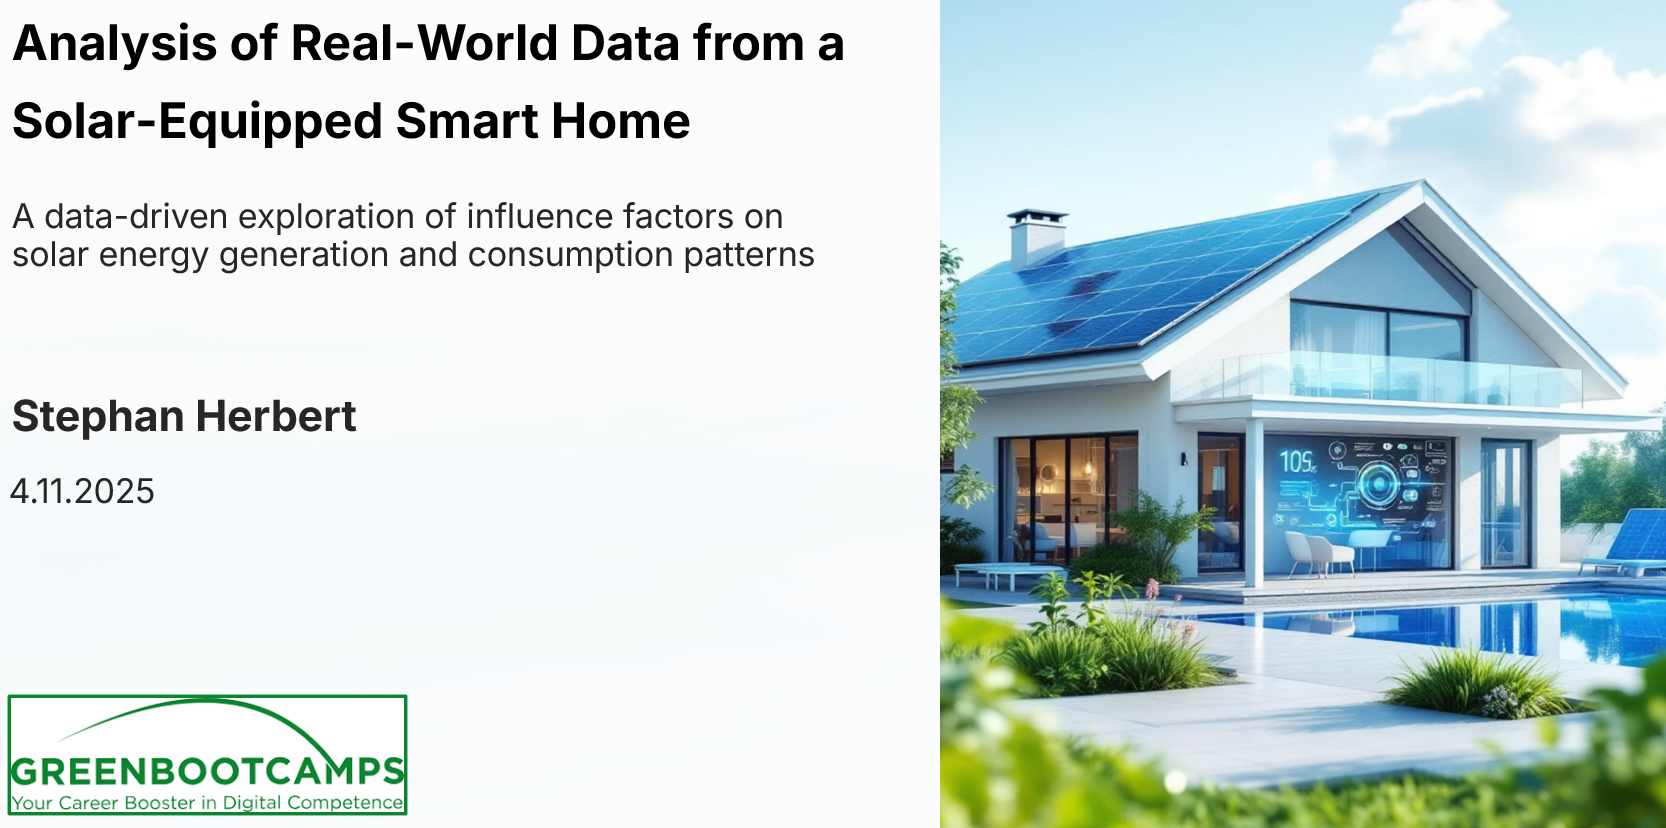

## Overview:
- ``Data source``: 
    - CSV-files  smart home system from my friend "Jürgen"

- ``Main target / tasks ()``:
    - Analyze energy + heating KPI's and give advises for stakeholder for savings

- ``Hypotheses``:
    1. Heating Usage: Heating is used even when outdoor temperature exceeds 15°C
    2. Solar energy: Season/month has greater impact on PV generation than weather conditions
    3. Energy Independence: Self-sufficiency is only achieved in Q2 and Q3
    4. Payback Period: Even under best conditions, the system amortization time can only be reduced by 1 year    compared to current conditions
    
    
    
    

## 1. Install packages

In [1]:
# pip install nbformat

In [2]:
# pip install waterfallcharts

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px

from pathlib import Path
import re

## 2. Hypotheses + Stakeholder needs:


``Hypotheses:`` <br>
1. Heating Usage
    - Heating is used even when outdoor temperature exceeds 15°C
2. Solar energy – Influence factors on PV-generation
    - Season/month has greater impact on PV generation than weather conditions
3. Energy Independence
    - Self-sufficiency is only achieved in Q2 and Q3
4. Optimization Potential   Payback Period
    -Even under best conditions, the system amortization time can only be reduced by 1 year    compared to current conditions
<br> <br>

``My stakeholder:   Jürgen`` <br>
- Retired engineer and tech enthusiast 
- Continuously optimizing his smart home system

## 3. Load data + data cleaning

In [4]:
# Read all CSV-files from folder "A_Energy"
data_folder = Path("data/A_Energy")
dfs = [pd.read_csv(file) for file in data_folder.glob("*.csv")]
combined_df = pd.concat(dfs, ignore_index=True)

In [5]:
combined_df.head()

,time,kWh.mean_value
0,2024-03-01T00:00:00.000+01:00,NaN
1,2024-03-01T00:10:00.000+01:00,NaN
2,2024-03-01T00:20:00.000+01:00,NaN
3,2024-03-01T00:30:00.000+01:00,NaN
4,2024-03-01T00:40:00.000+01:00,NaN


### Load different energy tables (solar, import, export...) from folder: 

In [6]:
# === Configuration ===
DATA_DIR = Path("data/A_Energy")         # folder with CSV files
RESAMPLE_RULE = None            # e.g. "1T" for 1-minute grid, or None to skip
LOCAL_TZ = "Europe/Berlin"      # only used if you convert from UTC later

def load_one_csv(path: Path) -> pd.Series:
    """Load one CSV -> return a time-indexed Series named after the file (without extension)."""
    # Read only the necessary columns for speed and clarity
    df = pd.read_csv(path, usecols=["time", "kWh.mean_value"])

    # Parse timestamps; utc=True silences mixed-timezone warnings and standardizes to UTC
    ts = pd.to_datetime(df["time"], errors="coerce", utc=True)

    # Build numeric Series with timestamp index
    s = pd.Series(pd.to_numeric(df["kWh.mean_value"], errors="coerce").values,
                  index=ts, name=path.stem)

    # Drop unparsable timestamps, sort, and aggregate duplicate timestamps (mean)
    s = s[~s.index.isna()].sort_index()
    if s.index.has_duplicates:
        s = s.groupby(level=0).mean()

    return s

def combine_folder(folder: Path, resample_rule: str | None = None) -> pd.DataFrame:
    """Outer-join all Series on their UTC timestamp index; optional resampling to a uniform grid."""
    series_list = []
    for file in sorted(folder.glob("*.csv")):
        try:
            series_list.append(load_one_csv(file))
        except Exception as e:
            print(f"⚠️  Skipping {file.name}: {e}")

    if not series_list:
        raise RuntimeError("No valid CSV files found in the folder.")

    # Outer join on index (timestamps) -> wide table with one column per file
    wide = pd.concat(series_list, axis=1)

    # Optional: resample to a uniform time grid (e.g., "1T", "5T", "1H", "1D")
    if resample_rule:
        wide = wide.resample(resample_rule).mean()

    return wide

# === Run ===
wide_df = combine_folder(DATA_DIR, resample_rule=RESAMPLE_RULE)

print(wide_df.shape)
print(wide_df.head())

# Optional: if you prefer local time for display/plots, convert from UTC:
# wide_df = wide_df.tz_convert(LOCAL_TZ)


(83370, 6)
                           A_PV-Energie_01-data_2024-03_2025-09_total-pv-generation_600s_kWh  \
time                                                                                           
2024-02-29 23:00:00+00:00                                                NaN                   
2024-02-29 23:10:00+00:00                                                NaN                   
2024-02-29 23:20:00+00:00                                                NaN                   
2024-02-29 23:30:00+00:00                                                NaN                   
2024-02-29 23:40:00+00:00                                                NaN                   

                           A_PV-Energie_02-data_2024-03_2025-09_total-consumed-energy_600s_kWh  \
time                                                                                             
2024-02-29 23:00:00+00:00                                                NaN                     
2024-02-29 23:10:00+00

In [7]:
# Shorten column names

def shorten_column_name(col_name):    
    parts = col_name.split("_")     # Split by underscores
    return parts[5]                 # part 5: e.g. total-pv-generation

# Apply to all column names
wide_df.columns = [shorten_column_name(col) for col in wide_df.columns]

# Print result
print(wide_df.columns)


Index(['total-pv-generation', 'total-consumed-energy', 'total-imported-energy',
       'total-exported-energy', 'total-battery-charge',
       'total-battery-discharge'],
      dtype='object')


In [8]:
# Create date column from index column
wide_df["date"] = wide_df.index.date

wide_df.tail()



,total-pv-generation,total-consumed-energy,total-imported-energy,total-exported-energy,total-battery-charge,total-battery-discharge,date
time,,,,,,,
2025-09-30 21:10:00+00:00,NaN,NaN,NaN,NaN,NaN,3688.3,2025-09-30
2025-09-30 21:20:00+00:00,NaN,NaN,NaN,NaN,NaN,3688.4,2025-09-30
2025-09-30 21:30:00+00:00,NaN,NaN,NaN,NaN,NaN,3688.5,2025-09-30
2025-09-30 21:40:00+00:00,NaN,NaN,2543.3,NaN,NaN,NaN,2025-09-30
2025-09-30 21:50:00+00:00,NaN,NaN,2543.4,NaN,NaN,NaN,2025-09-30


### Prepare data for aggregation (-> Daily max-value instead of running total)

In [9]:
import pandas as pd
import numpy as np

def subtract_prev_day_max(df, date_col="date"):
    """
    Subtracts the previous day's maximum value from each numeric column.
    This is useful for cumulative energy data where each new day should
    continue from zero relative to the previous day's end.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing at least one numeric column and a date column.
    date_col : str, default 'date'
        Column name containing the calendar date (e.g. '2024-02-29').

    Returns
    -------
    pandas.DataFrame
        Copy of the original DataFrame where numeric values are adjusted
        so that the previous day's maximum is subtracted from each day's values.
    """

    df = df.copy()

    # Ensure date column exists
    if date_col not in df.columns:
        raise ValueError(f"'{date_col}' column not found in DataFrame.")

    # Select numeric columns
    num_cols = df.select_dtypes(include="number").columns

    # Compute daily max per column
    daily_max = df.groupby(date_col)[num_cols].max()

    # Shift by one day → get the previous day's maximums
    prev_day_max = daily_max.shift(1)

    # Subtract previous day's max from each numeric column
    for col in num_cols:
        df[col] = df[col] - df[date_col].map(prev_day_max[col].to_dict())

    # Replace negative values (e.g., first day) with 0
    df[num_cols] = df[num_cols].clip(lower=0)

    return df


In [10]:
# Create new dataframe
wide_df_daily0 = subtract_prev_day_max(wide_df, date_col="date")

# Shorten column names (without "total-")
wide_df_daily0.columns = [col.replace( "total-", "") for col in wide_df_daily0.columns]



# Create date / year columns from index column
wide_df_daily0["date"] = wide_df_daily0.index.date
wide_df_daily0["month"] = wide_df_daily0.index.month
wide_df_daily0["quarter"] = wide_df_daily0.index.quarter
wide_df_daily0["year"] = wide_df_daily0.index.year
wide_df_daily0["year_quarter"] = wide_df_daily0.index.to_period("Q").astype(str).str.replace("Q", "_Q")   # Quarter -> to 2024_Q1

# Example output (max per day):
wide_df_daily0.groupby('date').max().isna().sum()

C:\Users\steph\AppData\Local\Temp\ipykernel_37920\2125492433.py:14: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  wide_df_daily0["year_quarter"] = wide_df_daily0.index.to_period("Q").astype(str).str.replace("Q", "_Q")   # Quarter -> to 2024_Q1


pv-generation         10
consumed-energy        6
imported-energy      239
exported-energy       87
battery-charge        12
battery-discharge     49
month                  0
quarter                0
year                   0
year_quarter           0
dtype: int64

In [11]:
wide_df_daily0


,pv-generation,consumed-energy,imported-energy,exported-energy,battery-charge,battery-discharge,date,month,quarter,year,year_quarter
time,,,,,,,,,,,
2024-02-29 23:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,2024-02-29,2,1,2024,2024_Q1
2024-02-29 23:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,2024-02-29,2,1,2024,2024_Q1
2024-02-29 23:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,2024-02-29,2,1,2024,2024_Q1
2024-02-29 23:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,2024-02-29,2,1,2024,2024_Q1
2024-02-29 23:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,2024-02-29,2,1,2024,2024_Q1
...,...,...,...,...,...,...,...,...,...,...,...
2025-09-30 21:10:00+00:00,NaN,NaN,NaN,NaN,NaN,4.5,2025-09-30,9,3,2025,2025_Q3
2025-09-30 21:20:00+00:00,NaN,NaN,NaN,NaN,NaN,4.6,2025-09-30,9,3,2025,2025_Q3
2025-09-30 21:30:00+00:00,NaN,NaN,NaN,NaN,NaN,4.7,2025-09-30,9,3,2025,2025_Q3


In [12]:
values_per_day = wide_df_daily0.groupby('date').max().round(2)

values_per_day.head(5)

,pv-generation,consumed-energy,imported-energy,exported-energy,battery-charge,battery-discharge,month,quarter,year,year_quarter
date,,,,,,,,,,
2024-02-29,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2024,2024_Q1
2024-03-01,NaN,NaN,NaN,NaN,NaN,6.6,3,1,2024,2024_Q1
2024-03-02,11.8,7.0,3.0,2.9,6.9,2.3,3,1,2024,2024_Q1
2024-03-03,21.6,10.0,NaN,12.3,6.4,6.8,3,1,2024,2024_Q1
2024-03-04,3.5,9.0,NaN,0.2,1.6,4.0,3,1,2024,2024_Q1


In [13]:
# Convert index to "data time"
values_per_day.index = pd.to_datetime(values_per_day.index)

values_per_day["date"] = values_per_day.index.date

values_per_day.head(2)

,pv-generation,consumed-energy,imported-energy,exported-energy,battery-charge,battery-discharge,month,quarter,year,year_quarter,date
date,,,,,,,,,,,
2024-02-29,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2024,2024_Q1,2024-02-29
2024-03-01,NaN,NaN,NaN,NaN,NaN,6.6,3,1,2024,2024_Q1,2024-03-01


In [14]:
values_per_day.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 580 entries, 2024-02-29 to 2025-09-30
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pv-generation      570 non-null    float64
 1   consumed-energy    574 non-null    float64
 2   imported-energy    341 non-null    float64
 3   exported-energy    493 non-null    float64
 4   battery-charge     568 non-null    float64
 5   battery-discharge  531 non-null    float64
 6   month              580 non-null    int32  
 7   quarter            580 non-null    int32  
 8   year               580 non-null    int32  
 9   year_quarter       580 non-null    object 
 10  date               580 non-null    object 
dtypes: float64(6), int32(3), object(2)
memory usage: 47.6+ KB


In [15]:
# Delete 1st row (only contains NaN-values)
values_per_day = values_per_day.drop(pd.Timestamp("2024-02-29"))
values_per_day.head(5)

,pv-generation,consumed-energy,imported-energy,exported-energy,battery-charge,battery-discharge,month,quarter,year,year_quarter,date
date,,,,,,,,,,,
2024-03-01,NaN,NaN,NaN,NaN,NaN,6.6,3,1,2024,2024_Q1,2024-03-01
2024-03-02,11.8,7.0,3.0,2.9,6.9,2.3,3,1,2024,2024_Q1,2024-03-02
2024-03-03,21.6,10.0,NaN,12.3,6.4,6.8,3,1,2024,2024_Q1,2024-03-03
2024-03-04,3.5,9.0,NaN,0.2,1.6,4.0,3,1,2024,2024_Q1,2024-03-04
2024-03-05,2.7,10.0,7.8,0.1,1.1,0.6,3,1,2024,2024_Q1,2024-03-05


### Fill all NaN with 0


In [16]:
# Fill all NaN with 0
values_per_day = values_per_day.fillna(0)

values_per_day.head(5)

,pv-generation,consumed-energy,imported-energy,exported-energy,battery-charge,battery-discharge,month,quarter,year,year_quarter,date
date,,,,,,,,,,,
2024-03-01,0.0,0.0,0.0,0.0,0.0,6.6,3,1,2024,2024_Q1,2024-03-01
2024-03-02,11.8,7.0,3.0,2.9,6.9,2.3,3,1,2024,2024_Q1,2024-03-02
2024-03-03,21.6,10.0,0.0,12.3,6.4,6.8,3,1,2024,2024_Q1,2024-03-03
2024-03-04,3.5,9.0,0.0,0.2,1.6,4.0,3,1,2024,2024_Q1,2024-03-04
2024-03-05,2.7,10.0,7.8,0.1,1.1,0.6,3,1,2024,2024_Q1,2024-03-05


In [17]:
values_per_day.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 579 entries, 2024-03-01 to 2025-09-30
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pv-generation      579 non-null    float64
 1   consumed-energy    579 non-null    float64
 2   imported-energy    579 non-null    float64
 3   exported-energy    579 non-null    float64
 4   battery-charge     579 non-null    float64
 5   battery-discharge  579 non-null    float64
 6   month              579 non-null    int32  
 7   quarter            579 non-null    int32  
 8   year               579 non-null    int32  
 9   year_quarter       579 non-null    object 
 10  date               579 non-null    object 
dtypes: float64(6), int32(3), object(2)
memory usage: 47.5+ KB


### Financial calculations
- Price "Imported energy":   0.40 € per kWh  --> loss
- Price "Exported energy":   0.082 € per kWh --> win for stakeholder ("Einspeisevergütung")

In [18]:
# Import costs (0.40 € per kWh)    (Import = NaN --> result = 0)
values_per_day["costs_import_loss"] = values_per_day["imported-energy"].fillna(0) * 0.40

# Export win (0.082 € per kWh)
values_per_day["costs_export_win"] = values_per_day["exported-energy"].fillna(0) * 0.082

# Former costs without solar panels: Consumed-Energy * 0.40 €/kWH
values_per_day["costs_consumed_without_PV"] = values_per_day["consumed-energy"].fillna(0) * 0.40

values_per_day.head()

,pv-generation,consumed-energy,imported-energy,exported-energy,battery-charge,battery-discharge,month,quarter,year,year_quarter,date,costs_import_loss,costs_export_win,costs_consumed_without_PV
date,,,,,,,,,,,,,,
2024-03-01,0.0,0.0,0.0,0.0,0.0,6.6,3,1,2024,2024_Q1,2024-03-01,0.00,0.0000,0.0
2024-03-02,11.8,7.0,3.0,2.9,6.9,2.3,3,1,2024,2024_Q1,2024-03-02,1.20,0.2378,2.8
2024-03-03,21.6,10.0,0.0,12.3,6.4,6.8,3,1,2024,2024_Q1,2024-03-03,0.00,1.0086,4.0
2024-03-04,3.5,9.0,0.0,0.2,1.6,4.0,3,1,2024,2024_Q1,2024-03-04,0.00,0.0164,3.6
2024-03-05,2.7,10.0,7.8,0.1,1.1,0.6,3,1,2024,2024_Q1,2024-03-05,3.12,0.0082,4.0


In [19]:
# Flag-column: if "imported-energy" = NaN -> 1, else 0
# values_per_day["day_import"] = np.where(values_per_day['imported-energy'] > 0, "Import", "No import")

# Categorize import values into three groups
values_per_day["day_import"] = np.select(
    [
        values_per_day['imported-energy'].between(0, 1, inclusive="neither"),  # between 0 and 1
        values_per_day['imported-energy'] > 1                                  # greater than 1
    ],
    [
        "Import < 1 kWh",   # first condition
        "Import"            # second condition
    ],
    default="No import"      # everything else (<= 0)
)


# Flag-column: if "battery-discharge" > "charge" -> 1, else 0
values_per_day["day_battery"] = np.where(values_per_day["battery-discharge"] > values_per_day["battery-charge"],  "Discharging", "Charging")

values_per_day

,pv-generation,consumed-energy,imported-energy,exported-energy,battery-charge,battery-discharge,month,quarter,year,year_quarter,date,costs_import_loss,costs_export_win,costs_consumed_without_PV,day_import,day_battery
date,,,,,,,,,,,,,,,,
2024-03-01,0.0,0.0,0.0,0.0,0.0,6.6,3,1,2024,2024_Q1,2024-03-01,0.00,0.0000,0.0,No import,Discharging
2024-03-02,11.8,7.0,3.0,2.9,6.9,2.3,3,1,2024,2024_Q1,2024-03-02,1.20,0.2378,2.8,Import,Charging
2024-03-03,21.6,10.0,0.0,12.3,6.4,6.8,3,1,2024,2024_Q1,2024-03-03,0.00,1.0086,4.0,No import,Discharging
2024-03-04,3.5,9.0,0.0,0.2,1.6,4.0,3,1,2024,2024_Q1,2024-03-04,0.00,0.0164,3.6,No import,Discharging
2024-03-05,2.7,10.0,7.8,0.1,1.1,0.6,3,1,2024,2024_Q1,2024-03-05,3.12,0.0082,4.0,Import,Charging
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-26,10.6,7.0,2.1,2.8,5.3,2.8,9,3,2025,2025_Q3,2025-09-26,0.84,0.2296,2.8,Import,Charging
2025-09-27,9.3,12.0,0.8,0.6,6.5,8.0,9,3,2025,2025_Q3,2025-09-27,0.32,0.0492,4.8,Import < 1 kWh,Discharging
2025-09-28,11.8,8.0,2.0,2.9,6.2,3.7,9,3,2025,2025_Q3,2025-09-28,0.80,0.2378,3.2,Import,Charging


In [20]:
values_per_day.columns

Index(['pv-generation', 'consumed-energy', 'imported-energy',
       'exported-energy', 'battery-charge', 'battery-discharge', 'month',
       'quarter', 'year', 'year_quarter', 'date', 'costs_import_loss',
       'costs_export_win', 'costs_consumed_without_PV', 'day_import',
       'day_battery'],
      dtype='object')

In [21]:

# Change order of columns (for waterfall diagram)
values_per_day = values_per_day[["pv-generation", "consumed-energy", 
                                 "battery-charge", "battery-discharge", 
                                 "imported-energy", "exported-energy", 
                                  "date", "month", "quarter", "year", "year_quarter",
                                  'costs_import_loss', 'costs_export_win', 'costs_consumed_without_PV', 
                                  'day_import', 'day_battery']]

values_per_day.head()

,pv-generation,consumed-energy,battery-charge,battery-discharge,imported-energy,exported-energy,date,month,quarter,year,year_quarter,costs_import_loss,costs_export_win,costs_consumed_without_PV,day_import,day_battery
date,,,,,,,,,,,,,,,,
2024-03-01,0.0,0.0,0.0,6.6,0.0,0.0,2024-03-01,3,1,2024,2024_Q1,0.00,0.0000,0.0,No import,Discharging
2024-03-02,11.8,7.0,6.9,2.3,3.0,2.9,2024-03-02,3,1,2024,2024_Q1,1.20,0.2378,2.8,Import,Charging
2024-03-03,21.6,10.0,6.4,6.8,0.0,12.3,2024-03-03,3,1,2024,2024_Q1,0.00,1.0086,4.0,No import,Discharging
2024-03-04,3.5,9.0,1.6,4.0,0.0,0.2,2024-03-04,3,1,2024,2024_Q1,0.00,0.0164,3.6,No import,Discharging
2024-03-05,2.7,10.0,1.1,0.6,7.8,0.1,2024-03-05,3,1,2024,2024_Q1,3.12,0.0082,4.0,Import,Charging


## 4.) Outlier check

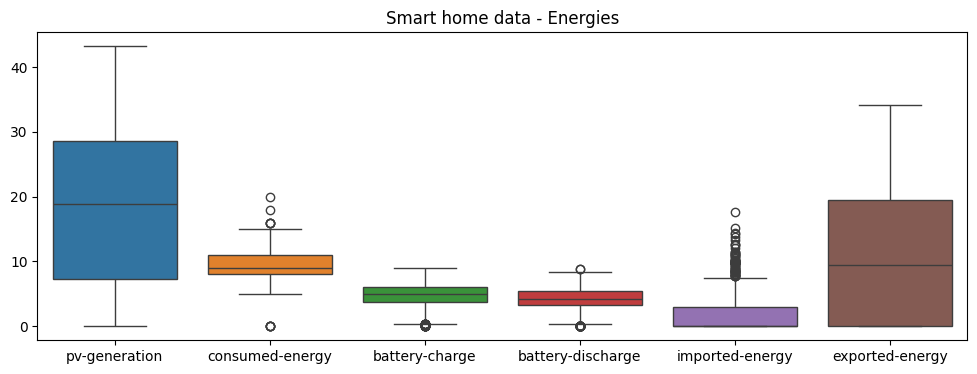

In [41]:
# Boxplot <=> Outliers   - Smart home data
plt.figure(figsize=(12,4))
sns.boxplot(values_per_day[["pv-generation", "consumed-energy", 
                                 "battery-charge", "battery-discharge", 
                                 "imported-energy", "exported-energy" ]])
# plt.ylim(60,74)
plt.title("Smart home data - Energies")
plt.show()

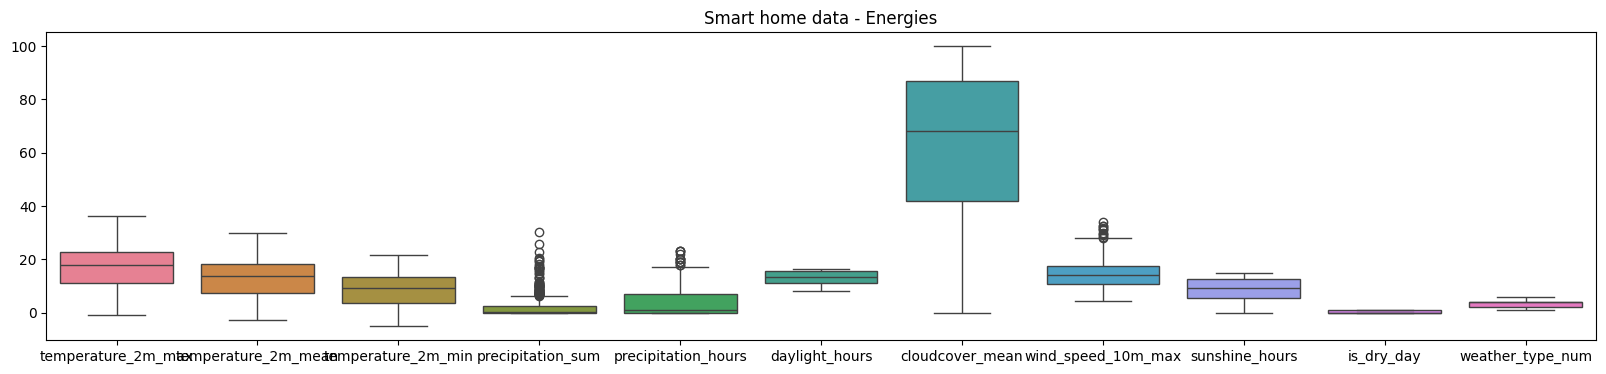

In [ ]:
# Boxplot <=> Outliers   - Weather data
plt.figure(figsize=(20,4))
sns.boxplot(house_weather[['temperature_2m_max', 'temperature_2m_mean',
       'temperature_2m_min', 'precipitation_sum', 'precipitation_hours',
       'daylight_hours', 'cloudcover_mean', 'wind_speed_10m_max',
       'weathercode_text', 'sunshine_hours', 'precip_category', 'weather_type',
       'is_dry_day', 'weather_type_num' ]])
# plt.ylim(60,74)
plt.title("Smart home data - Energies")
plt.show()

## 5.) Export CSV file --> Power BI

In [ ]:
# Export daily values to CSV
values_per_day.to_csv("export-file.csv", index=True)